In [204]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython
from IPython.display import Audio
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
print(f'tensorflow version: {tf.__version__}')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

tensorflow version: 2.7.0


In [2]:
tqdm_notebook.pandas()

### Reviewing Dataset

In [111]:
for index, filename in enumerate(os.listdir('cat')):
    os.rename(f'cat/{filename}', f'cat/{str(index)}.wav')
    
for index,filename in enumerate(os.listdir('dog')):
    os.rename(f'dog/{filename}', f'dog/{str(index)}.wav')

In [112]:
IPython.display.display(IPython.display.Audio('cat/0.wav'))
IPython.display.display(IPython.display.Audio('cat/1.wav'))

In [113]:
IPython.display.display(IPython.display.Audio('dog/0.wav'))
IPython.display.display(IPython.display.Audio('dog/1.wav'))

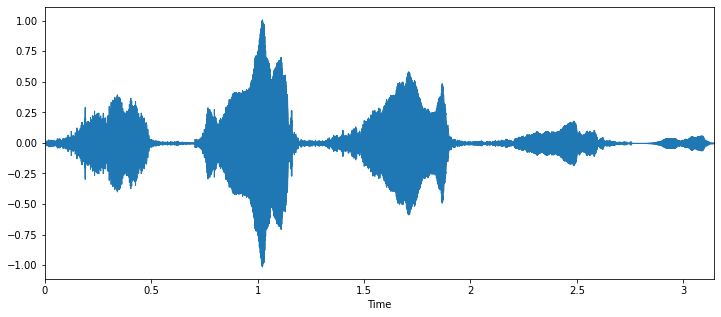

In [114]:
audio, sr = librosa.load('cat/1.wav')
plt.figure(figsize=(12,5))
librosa.display.waveplot(audio, sr)

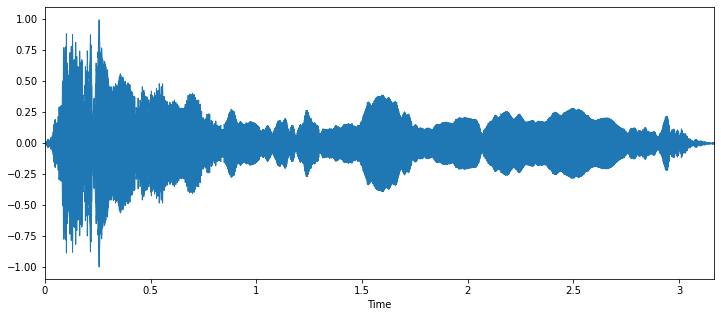

In [115]:
audio, sr = librosa.load('dog/1.wav')
plt.figure(figsize=(12,5))
librosa.display.waveplot(audio, sr)

## Data Preprocessing

In [116]:
cat_audio_list = []
for i in range(len(os.listdir('cat'))):
    cat_audio_list.append(f'cat/{i}.wav')
    
dog_audio_list = []
for i in range(len(os.listdir('dog'))):
    dog_audio_list.append(f'dog/{i}.wav')

In [117]:
df = pd.DataFrame()

In [118]:
cat_audio_data = []
for filename in cat_audio_list:
    cat_audio_data.append({
        'filename': filename,
        'label': 'cat'
    })
df = df.append(pd.DataFrame(cat_audio_data), ignore_index=True)
    
dog_audio_data = []
for filename in dog_audio_list:
    dog_audio_data.append({
        'filename': filename,
        'label': 'dog'
    })
df = df.append(pd.DataFrame(dog_audio_data),  ignore_index=True)

In [119]:
df

,filename,label
0,cat/0.wav,cat
1,cat/1.wav,cat
2,cat/2.wav,cat
3,cat/3.wav,cat
4,cat/4.wav,cat
...,...,...
265,dog/103.wav,dog
266,dog/104.wav,dog
267,dog/105.wav,dog
268,dog/106.wav,dog


In [120]:
df['is_dog'] = pd.get_dummies(df['label'], drop_first=True)

In [121]:
df['audio'] = df['filename'].progress_apply(lambda x: librosa.load(x)[0])
df['sr'] = 22050

  0%|          | 0/270 [00:00<?, ?it/s]

In [122]:
df['mfcc'] = df['audio'].progress_apply(lambda x: librosa.feature.mfcc(x, n_mfcc=12))

  0%|          | 0/270 [00:00<?, ?it/s]

In [123]:
df['mfcc_mean'] = df['mfcc'].progress_apply(lambda x: np.mean(x.T, axis=0))

  0%|          | 0/270 [00:00<?, ?it/s]

In [125]:
df.to_pickle('data.pkl')

## Training Model

In [183]:
df = pd.read_pickle('data.pkl')

In [184]:
X = np.vstack(df['mfcc_mean'].to_numpy())
y = df['is_dog'].to_numpy().reshape(-1,1).astype('float32')

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

In [186]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0., 1.], dtype=float32), array([112,  77], dtype=int64))
(array([0., 1.], dtype=float32), array([50, 31], dtype=int64))


In [187]:
model = Sequential(
    [
        Input(shape=(12,)),
        Dense(100, activation='relu', name='layer_1'),
        Dropout(0.5),
        Dense(200, activation='relu', name='layer_2'),
        Dropout(0.5),
        Dense(200, activation='relu', name='layer_3'),
        Dropout(0.5),
        Dense(100, activation='relu', name='layer_4'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', name='output_layer'),
    ]
)

In [188]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 100)               1300      
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 layer_2 (Dense)             (None, 200)               20200     
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 layer_3 (Dense)             (None, 200)               40200     
                                                                 
 dropout_14 (Dropout)        (None, 200)               0         
                                                                 
 layer_4 (Dense)             (None, 100)              

In [189]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [190]:
log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [191]:
%%time
num_epochs = 300
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='models/best_4.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(X_train, 
          y_train, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(X_test, y_test), 
          callbacks=[checkpointer, tensorboard_callback], 
          verbose=1)

Epoch 1/300
1/6 [====>.........................] - ETA: 2s - loss: 19.7798 - accuracy: 0.5000
Epoch 00001: val_loss improved from inf to 6.34218, saving model to models\best_4.hdf5
6/6 [==============================] - 1s 43ms/step - loss: 15.0025 - accuracy: 0.5132 - val_loss: 6.3422 - val_accuracy: 0.6173
Epoch 2/300
1/6 [====>.........................] - ETA: 0s - loss: 19.3284 - accuracy: 0.4688
Epoch 00002: val_loss improved from 6.34218 to 1.67007, saving model to models\best_4.hdf5
6/6 [==============================] - 0s 23ms/step - loss: 13.7071 - accuracy: 0.5291 - val_loss: 1.6701 - val_accuracy: 0.6173
Epoch 3/300
1/6 [====>.........................] - ETA: 0s - loss: 18.4730 - accuracy: 0.5938
Epoch 00003: val_loss improved from 1.67007 to 0.75957, saving model to models\best_4.hdf5
6/6 [==============================] - 0s 24ms/step - loss: 10.5865 - accuracy: 0.5556 - val_loss: 0.7596 - val_accuracy: 0.7037
Epoch 4/300
1/6 [====>.........................] - ETA: 0s - l

1/6 [====>.........................] - ETA: 0s - loss: 2.0028 - accuracy: 0.5000
Epoch 00029: val_loss did not improve from 0.35777
6/6 [==============================] - 0s 19ms/step - loss: 1.2293 - accuracy: 0.6614 - val_loss: 0.3696 - val_accuracy: 0.8765
Epoch 30/300
1/6 [====>.........................] - ETA: 0s - loss: 2.0012 - accuracy: 0.5625
Epoch 00030: val_loss did not improve from 0.35777
6/6 [==============================] - 0s 19ms/step - loss: 1.0526 - accuracy: 0.7354 - val_loss: 0.3639 - val_accuracy: 0.8765
Epoch 31/300
1/6 [====>.........................] - ETA: 0s - loss: 1.5151 - accuracy: 0.6250
Epoch 00031: val_loss did not improve from 0.35777
6/6 [==============================] - 0s 17ms/step - loss: 1.4395 - accuracy: 0.5714 - val_loss: 0.3590 - val_accuracy: 0.8642
Epoch 32/300
1/6 [====>.........................] - ETA: 0s - loss: 0.7633 - accuracy: 0.7812
Epoch 00032: val_loss improved from 0.35777 to 0.35650, saving model to models\best_4.hdf5
6/6 [====

Epoch 59/300
1/6 [====>.........................] - ETA: 0s - loss: 0.4396 - accuracy: 0.8125
Epoch 00059: val_loss did not improve from 0.35216
6/6 [==============================] - 0s 17ms/step - loss: 0.6953 - accuracy: 0.7143 - val_loss: 0.3599 - val_accuracy: 0.9012
Epoch 60/300
1/6 [====>.........................] - ETA: 0s - loss: 0.4630 - accuracy: 0.8125
Epoch 00060: val_loss did not improve from 0.35216
6/6 [==============================] - 0s 16ms/step - loss: 0.5082 - accuracy: 0.8042 - val_loss: 0.3613 - val_accuracy: 0.9012
Epoch 61/300
1/6 [====>.........................] - ETA: 0s - loss: 0.5711 - accuracy: 0.6562
Epoch 00061: val_loss did not improve from 0.35216
6/6 [==============================] - 0s 16ms/step - loss: 0.6902 - accuracy: 0.7090 - val_loss: 0.3634 - val_accuracy: 0.9012
Epoch 62/300
1/6 [====>.........................] - ETA: 0s - loss: 0.6986 - accuracy: 0.7188
Epoch 00062: val_loss did not improve from 0.35216
6/6 [==============================]

1/6 [====>.........................] - ETA: 0s - loss: 0.5157 - accuracy: 0.8750
Epoch 00088: val_loss did not improve from 0.32514
6/6 [==============================] - 0s 17ms/step - loss: 0.3725 - accuracy: 0.8677 - val_loss: 0.3421 - val_accuracy: 0.9136
Epoch 89/300
1/6 [====>.........................] - ETA: 0s - loss: 0.2007 - accuracy: 0.9375
Epoch 00089: val_loss did not improve from 0.32514
6/6 [==============================] - 0s 21ms/step - loss: 0.4961 - accuracy: 0.7884 - val_loss: 0.3412 - val_accuracy: 0.9136
Epoch 90/300
1/6 [====>.........................] - ETA: 0s - loss: 0.3983 - accuracy: 0.8438
Epoch 00090: val_loss did not improve from 0.32514
6/6 [==============================] - 0s 22ms/step - loss: 0.4636 - accuracy: 0.8677 - val_loss: 0.3422 - val_accuracy: 0.8889
Epoch 91/300
1/6 [====>.........................] - ETA: 0s - loss: 0.4081 - accuracy: 0.8125
Epoch 00091: val_loss did not improve from 0.32514
6/6 [==============================] - 0s 18ms/st

6/6 [==============================] - 0s 15ms/step - loss: 0.3976 - accuracy: 0.8307 - val_loss: 0.3069 - val_accuracy: 0.9136
Epoch 117/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1345 - accuracy: 0.9688
Epoch 00117: val_loss did not improve from 0.30082
6/6 [==============================] - 0s 16ms/step - loss: 0.3910 - accuracy: 0.8571 - val_loss: 0.3102 - val_accuracy: 0.9136
Epoch 118/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1613 - accuracy: 0.9062
Epoch 00118: val_loss did not improve from 0.30082
6/6 [==============================] - 0s 15ms/step - loss: 0.3741 - accuracy: 0.8466 - val_loss: 0.3127 - val_accuracy: 0.9136
Epoch 119/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1874 - accuracy: 0.9062
Epoch 00119: val_loss did not improve from 0.30082
6/6 [==============================] - 0s 15ms/step - loss: 0.3873 - accuracy: 0.8148 - val_loss: 0.3134 - val_accuracy: 0.9012
Epoch 120/300
1/6 [====>.........................]

Epoch 00144: val_loss did not improve from 0.26839
6/6 [==============================] - 0s 15ms/step - loss: 0.2995 - accuracy: 0.8677 - val_loss: 0.2732 - val_accuracy: 0.9136
Epoch 145/300
1/6 [====>.........................] - ETA: 0s - loss: 0.4778 - accuracy: 0.7500
Epoch 00145: val_loss did not improve from 0.26839
6/6 [==============================] - 0s 15ms/step - loss: 0.4166 - accuracy: 0.8254 - val_loss: 0.2796 - val_accuracy: 0.9136
Epoch 146/300
1/6 [====>.........................] - ETA: 0s - loss: 0.5501 - accuracy: 0.9375
Epoch 00146: val_loss did not improve from 0.26839
6/6 [==============================] - 0s 17ms/step - loss: 0.3888 - accuracy: 0.8677 - val_loss: 0.2865 - val_accuracy: 0.9136
Epoch 147/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1746 - accuracy: 0.9062
Epoch 00147: val_loss did not improve from 0.26839
6/6 [==============================] - 0s 18ms/step - loss: 0.2926 - accuracy: 0.9048 - val_loss: 0.2859 - val_accuracy: 0.9136

1/6 [====>.........................] - ETA: 0s - loss: 0.2316 - accuracy: 0.8750
Epoch 00173: val_loss did not improve from 0.25696
6/6 [==============================] - 0s 16ms/step - loss: 0.2924 - accuracy: 0.8889 - val_loss: 0.2642 - val_accuracy: 0.9136
Epoch 174/300
1/6 [====>.........................] - ETA: 0s - loss: 0.2070 - accuracy: 0.9062
Epoch 00174: val_loss did not improve from 0.25696
6/6 [==============================] - 0s 16ms/step - loss: 0.2458 - accuracy: 0.8942 - val_loss: 0.2635 - val_accuracy: 0.9136
Epoch 175/300
1/6 [====>.........................] - ETA: 0s - loss: 0.4479 - accuracy: 0.8438
Epoch 00175: val_loss did not improve from 0.25696
6/6 [==============================] - 0s 16ms/step - loss: 0.3500 - accuracy: 0.8836 - val_loss: 0.2647 - val_accuracy: 0.9136
Epoch 176/300
1/6 [====>.........................] - ETA: 0s - loss: 0.4110 - accuracy: 0.8125
Epoch 00176: val_loss did not improve from 0.25696
6/6 [==============================] - 0s 16ms

1/6 [====>.........................] - ETA: 0s - loss: 0.3107 - accuracy: 0.8438
Epoch 00201: val_loss did not improve from 0.24273
6/6 [==============================] - 0s 15ms/step - loss: 0.2999 - accuracy: 0.9101 - val_loss: 0.2433 - val_accuracy: 0.9136
Epoch 202/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1301 - accuracy: 0.9688
Epoch 00202: val_loss did not improve from 0.24273
6/6 [==============================] - 0s 15ms/step - loss: 0.2381 - accuracy: 0.9048 - val_loss: 0.2431 - val_accuracy: 0.9136
Epoch 203/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1130 - accuracy: 0.9688
Epoch 00203: val_loss improved from 0.24273 to 0.24184, saving model to models\best_4.hdf5
6/6 [==============================] - 0s 21ms/step - loss: 0.2304 - accuracy: 0.9153 - val_loss: 0.2418 - val_accuracy: 0.9136
Epoch 204/300
1/6 [====>.........................] - ETA: 0s - loss: 0.3154 - accuracy: 0.9375
Epoch 00204: val_loss did not improve from 0.24184
6/6 [=

Epoch 230/300
1/6 [====>.........................] - ETA: 0s - loss: 0.4297 - accuracy: 0.9062
Epoch 00230: val_loss did not improve from 0.23759
6/6 [==============================] - 0s 16ms/step - loss: 0.2142 - accuracy: 0.9312 - val_loss: 0.2393 - val_accuracy: 0.9136
Epoch 231/300
1/6 [====>.........................] - ETA: 0s - loss: 0.2641 - accuracy: 0.8438
Epoch 00231: val_loss did not improve from 0.23759
6/6 [==============================] - 0s 16ms/step - loss: 0.2264 - accuracy: 0.8995 - val_loss: 0.2396 - val_accuracy: 0.9136
Epoch 232/300
1/6 [====>.........................] - ETA: 0s - loss: 0.3240 - accuracy: 0.7812
Epoch 00232: val_loss did not improve from 0.23759
6/6 [==============================] - 0s 15ms/step - loss: 0.2236 - accuracy: 0.9101 - val_loss: 0.2383 - val_accuracy: 0.9136
Epoch 233/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1861 - accuracy: 0.9062
Epoch 00233: val_loss did not improve from 0.23759
6/6 [===========================

Epoch 00259: val_loss did not improve from 0.23633
6/6 [==============================] - 0s 17ms/step - loss: 0.1866 - accuracy: 0.9206 - val_loss: 0.2373 - val_accuracy: 0.9136
Epoch 260/300
1/6 [====>.........................] - ETA: 0s - loss: 0.0994 - accuracy: 0.9688
Epoch 00260: val_loss did not improve from 0.23633
6/6 [==============================] - 0s 17ms/step - loss: 0.2385 - accuracy: 0.8995 - val_loss: 0.2375 - val_accuracy: 0.9136
Epoch 261/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1627 - accuracy: 0.9688
Epoch 00261: val_loss did not improve from 0.23633
6/6 [==============================] - 0s 16ms/step - loss: 0.2160 - accuracy: 0.9365 - val_loss: 0.2382 - val_accuracy: 0.9136
Epoch 262/300
1/6 [====>.........................] - ETA: 0s - loss: 0.2545 - accuracy: 0.9062
Epoch 00262: val_loss did not improve from 0.23633
6/6 [==============================] - 0s 18ms/step - loss: 0.2028 - accuracy: 0.9259 - val_loss: 0.2399 - val_accuracy: 0.9136

1/6 [====>.........................] - ETA: 0s - loss: 0.1770 - accuracy: 0.9375
Epoch 00289: val_loss did not improve from 0.23633
6/6 [==============================] - 0s 15ms/step - loss: 0.2369 - accuracy: 0.9259 - val_loss: 0.2364 - val_accuracy: 0.9012
Epoch 290/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1022 - accuracy: 0.9688
Epoch 00290: val_loss improved from 0.23633 to 0.23623, saving model to models\best_4.hdf5
6/6 [==============================] - 0s 23ms/step - loss: 0.1480 - accuracy: 0.9418 - val_loss: 0.2362 - val_accuracy: 0.9012
Epoch 291/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1858 - accuracy: 0.9062
Epoch 00291: val_loss improved from 0.23623 to 0.23505, saving model to models\best_4.hdf5
6/6 [==============================] - 0s 22ms/step - loss: 0.1923 - accuracy: 0.9206 - val_loss: 0.2350 - val_accuracy: 0.9012
Epoch 292/300
1/6 [====>.........................] - ETA: 0s - loss: 0.1399 - accuracy: 0.9688
Epoch 00292: val_

In [52]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [192]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 9296), started 3:14:37 ago. (Use '!kill 9296' to kill it.)

## Evaluate and Run model

In [194]:
model = tf.keras.models.load_model('models/best_4.hdf5')

In [195]:
def extract_mean_mfcc(filename):
    audio, _ = librosa.load(filename)
    mfcc = librosa.feature.mfcc(audio, n_mfcc=12)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

In [196]:
def predict_class(model, filename):
    test_input = extract_mean_mfcc(filename).reshape(1,-1)
    proba = model.predict(test_input)
#     return proba
    if proba <= 0.5: 
        return 'cat'
    else: 
        return 'dog'

In [200]:
y_pred = (model.predict(X_train) > 0.5).astype("int32")
confusion_matrix(y_train, y_pred)

array([[111,   1],
       [  9,  68]], dtype=int64)

In [199]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
confusion_matrix(y_test, y_pred)

array([[47,  3],
       [ 5, 26]], dtype=int64)

In [201]:
predict_class(model, 'cat_test.wav')

'cat'

In [202]:
predict_class(model, 'dog_test.wav')

'dog'

In [203]:
predict_class(model, 'dog_test_noise.wav')

'dog'